# Load latency data and calculate the latency

In [1]:
import os
import numpy as np
import load_intan_rhd_format

# 202410331 Latency test for Retrocue tasks
# root='C:\\Users\\bl314\\Box\\CoganLab\\IndividualMeetings\\Baishen\\Retro_Script_latency_test_20241031'
# results = load_intan_rhd_format.read_data(os.path.join(root,"baishen_trigger_click_241031_155023","baishen_trigger_click_241031_155023.rhd"))

# 20241112 Latency test for Phoneme sequencing tasks: Old
# root='C:\\Users\\bl314\\Box\\CoganLab\\IndividualMeetings\\Baishen\\Retro_Phonseq_Script_latency_test_20241112'
# results = load_intan_rhd_format.read_data(os.path.join(root,"phonSeq_trigger_click_241112_102350","phonSeq_trigger_click_241112_102350.rhd"))

# 20241112 Latency test for Phoneme sequencing tasks: After updating buffer strategy
root='C:\\Users\\bl314\\Box\\CoganLab\\IndividualMeetings\\Baishen\\Retro_Phonseq_Script_latency_test_20241112'
results = load_intan_rhd_format.read_data(os.path.join(root,"phonSeq_trigger_click_newBuffer_241112_102928","phonSeq_trigger_click_newBuffer_241112_102928.rhd"))



Reading Intan Technologies RHD Data File, Version 3.0

Found 0 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 2 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 60.000 seconds of data.  Amplifiers were sampled at 20.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.6 seconds


### Version 1: same clicks for all trials

In [2]:
t=results["t_board_adc"]
data=results["board_adc_data"]
marker=data[0,:]-0.1
microphone=data[1,:]

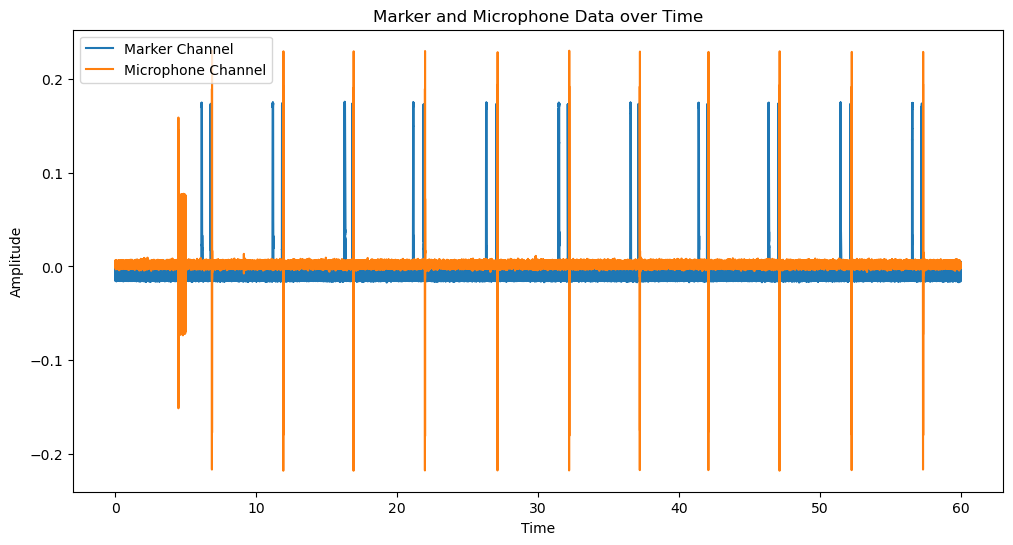

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(t, marker, label="Marker Channel")
plt.plot(t, microphone, label="Microphone Channel")
plt.title("Marker and Microphone Data over Time")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

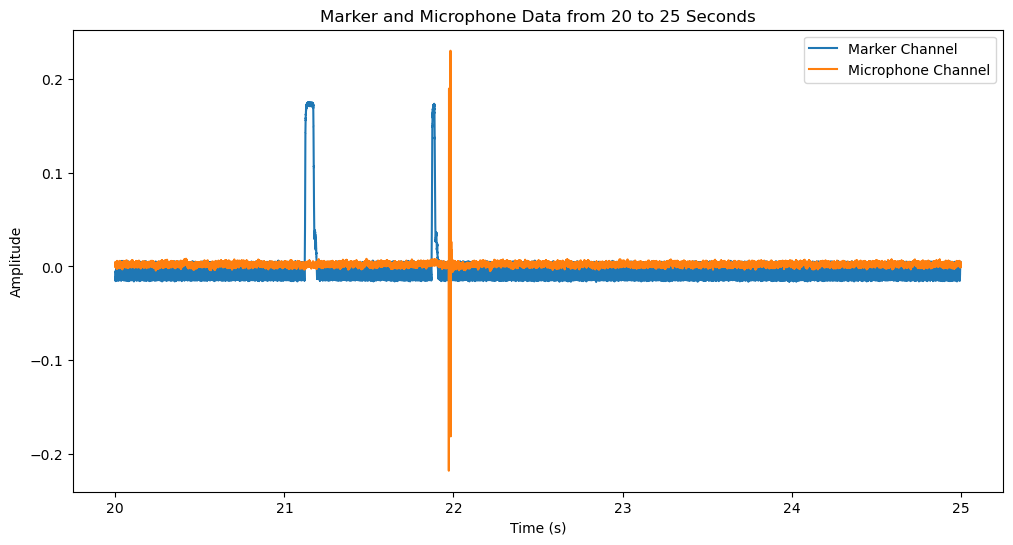

In [4]:
mask = (t >= 20) & (t <= 25)
t_range = t[mask]
marker_range = marker[mask]
microphone_range = microphone[mask]

plt.figure(figsize=(12, 6))
plt.plot(t_range, marker_range, label="Marker Channel")
plt.plot(t_range, microphone_range, label="Microphone Channel")
plt.title("Marker and Microphone Data from 20 to 25 Seconds")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

In [5]:
def plot_peaks_within_interval(t, marker, microphone, start_time, end_time, threshold=0.1, window_ms=200):
    # Select the interval based on start and end time
    mask = (t >= start_time) & (t <= end_time)
    t_range = t[mask]
    marker_range = marker[mask]
    microphone_range = microphone[mask]

    # Convert the window from milliseconds to samples
    window_samples = int(window_ms * (len(t_range) / (t_range[-1] - t_range[0])) / 1000)

    # Lists to store detected peaks
    peaks_microphone = []
    peaks_marker = []

    i = 0
    while i < len(t_range):
        # Step 1: Find the first point in microphone data above the threshold
        if microphone_range[i] > threshold:
            peak_microphone_idx = i
            peak_microphone_time = t_range[peak_microphone_idx]
            peaks_microphone.append(peak_microphone_time)

            # Step 2: Backtrace in marker data to find the closest peak before peak_microphone
            j = peak_microphone_idx
            while j > max(0, peak_microphone_idx - window_samples):
                if marker_range[j] > threshold:
                    # Identify the end point of the peak in marker
                    peak_marker_end = j
                    marker_window = marker_range[max(0, peak_marker_end - window_samples):peak_marker_end]
                    
                    # Find the first point in the window above the threshold
                    for k in range(len(marker_window)):
                        if marker_window[k] > threshold:
                            peak_marker_time = t_range[max(0, peak_marker_end - window_samples) + k]
                            peaks_marker.append(peak_marker_time)
                            break
                    break
                j -= 1

            # Step 3: Move index forward by 200ms worth of samples after peak_microphone
            i = peak_microphone_idx + window_samples
        else:
            i += 1

    # Plot data and detected peaks
    plt.figure(figsize=(12, 6))
    plt.plot(t_range, marker_range, label="Marker Channel")
    plt.plot(t_range, microphone_range, label="Microphone Channel")

    # Mark detected peaks on the plot
    plt.scatter(peaks_microphone, [0.1] * len(peaks_microphone), color='red', label="Microphone Peaks", zorder=5)
    plt.scatter(peaks_marker, [0.1] * len(peaks_marker), color='green', label="Marker Peaks", zorder=5)

    plt.title(f"Marker and Microphone Data from {start_time} to {end_time} Seconds with Peaks")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()

    # Calculate and print distances between pairs of peaks
    distances = []
    for peak_microphone, peak_marker in zip(peaks_microphone, peaks_marker):
        distance = peak_microphone - peak_marker  # Time difference
        distances.append(distance)

    return distances

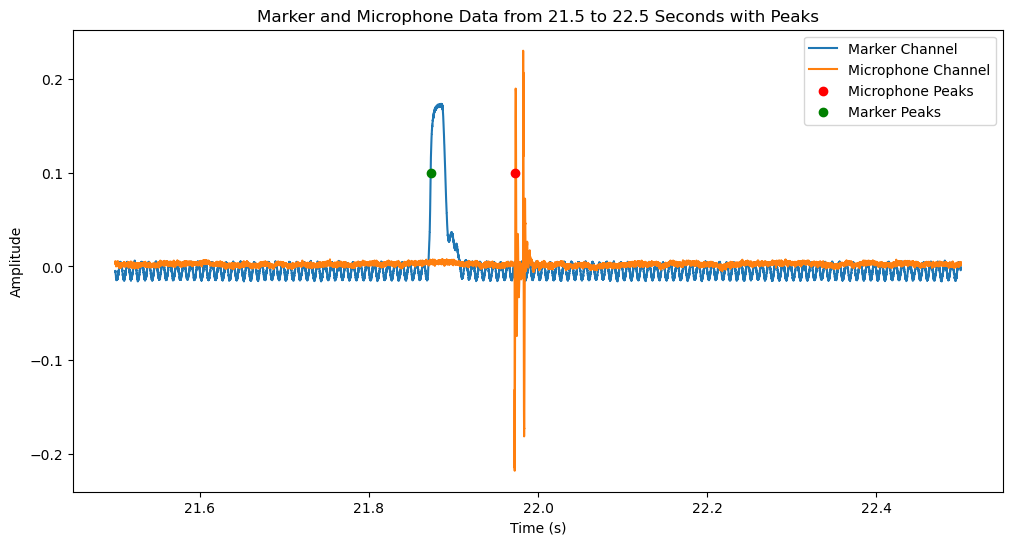

Distances between peaks (in seconds): [np.float64(0.10004999999999953)]


In [7]:

# Example of function usage:
distances = plot_peaks_within_interval(
    t=t,
    marker=marker,
    microphone=microphone,
    start_time=21.5,
    end_time=22.5
)
print("Distances between peaks (in seconds):", distances)


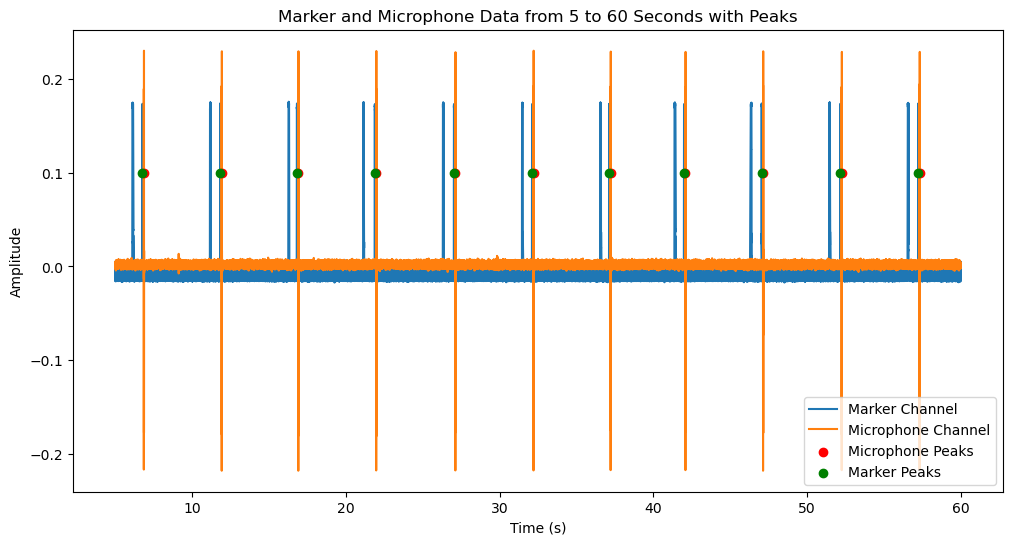

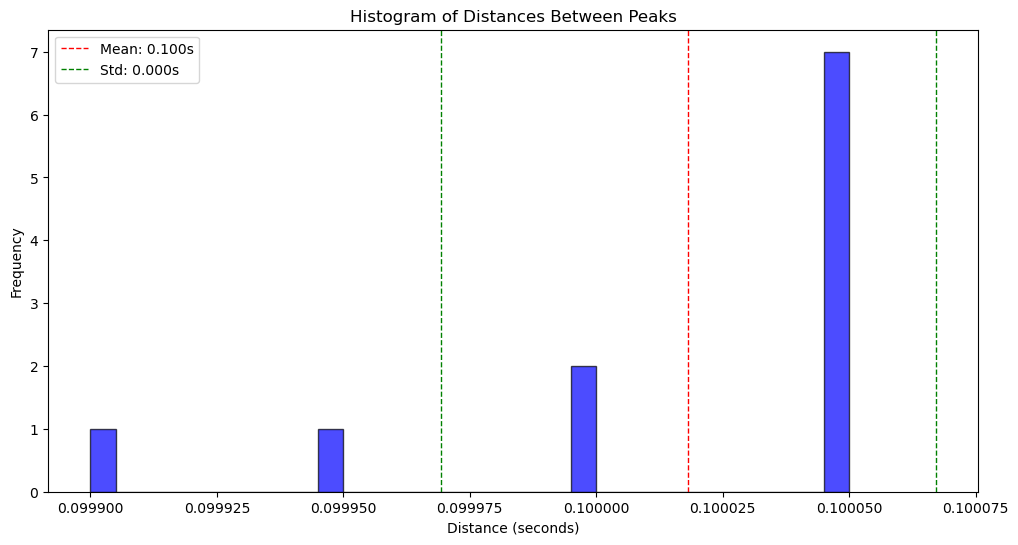

In [8]:

# Example of function usage:
distances = plot_peaks_within_interval(
    t=t,
    marker=marker,
    microphone=microphone,
    start_time=5,
    end_time=60
)
# Calculate mean and standard deviation

# Convert distances to numpy array for calculations
distances_array = np.array(distances)
mean_distance = np.mean(distances_array)
std_distance = np.std(distances_array)

# Plot histogram of distances
plt.figure(figsize=(12, 6))
plt.hist(distances_array, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Distances Between Peaks")
plt.xlabel("Distance (seconds)")
plt.ylabel("Frequency")
plt.axvline(mean_distance, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_distance:.3f}s')
plt.axvline(mean_distance + std_distance, color='green', linestyle='dashed', linewidth=1, label=f'Std: {std_distance:.3f}s')
plt.axvline(mean_distance - std_distance, color='green', linestyle='dashed', linewidth=1)
plt.legend()
plt.show()

In [10]:
all_t = []
all_marker = []
all_microphone = []

#data_dir=os.path.join(root,"baishen_trigger_click_241031_155023")
data_dir=os.path.join(root,"phonSeq_trigger_click_newBuffer_241112_102928")
# Traverse all files in the specified root folder
for filename in os.listdir(data_dir):
    if filename.endswith(".rhd"):
        file_path = os.path.join(data_dir, filename)
        results = load_intan_rhd_format.read_data(file_path)

        # Extract time and data
        t = results["t_board_adc"]
        data = results["board_adc_data"]

        # Extract marker and microphone data
        marker = data[0, :] - 0.1  # Adjust marker as needed
        microphone = data[1, :]

        # Append to the lists
        all_t.append(t)
        all_marker.append(marker)
        all_microphone.append(microphone)

# Concatenate all the arrays into single arrays
all_t = np.concatenate(all_t)
all_marker = np.concatenate(all_marker)
all_microphone = np.concatenate(all_microphone)


Reading Intan Technologies RHD Data File, Version 3.0

Found 0 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 2 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 60.000 seconds of data.  Amplifiers were sampled at 20.00 kS/s.

Allocating memory for data...
Reading data from file...
10% done...
20% done...
30% done...
40% done...
50% done...
60% done...
70% done...
80% done...
90% done...
Parsing data...
No missing timestamps in data.
Done!  Elapsed time: 0.6 seconds

Reading Intan Technologies RHD Data File, Version 3.0

Found 0 amplifier channels.
Found 0 auxiliary input channels.
Found 0 supply voltage channels.
Found 2 board ADC channels.
Found 0 board digital input channels.
Found 0 board digital output channels.
Found 0 temperature sensors channels.

File contains 60.000 seconds of data.  Amplifiers were sampled at 20.00 kS/s.

Allocati

C:\Users\bl314\AppData\Local\miniconda3\envs\lexical_retro_delay_expdesign\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


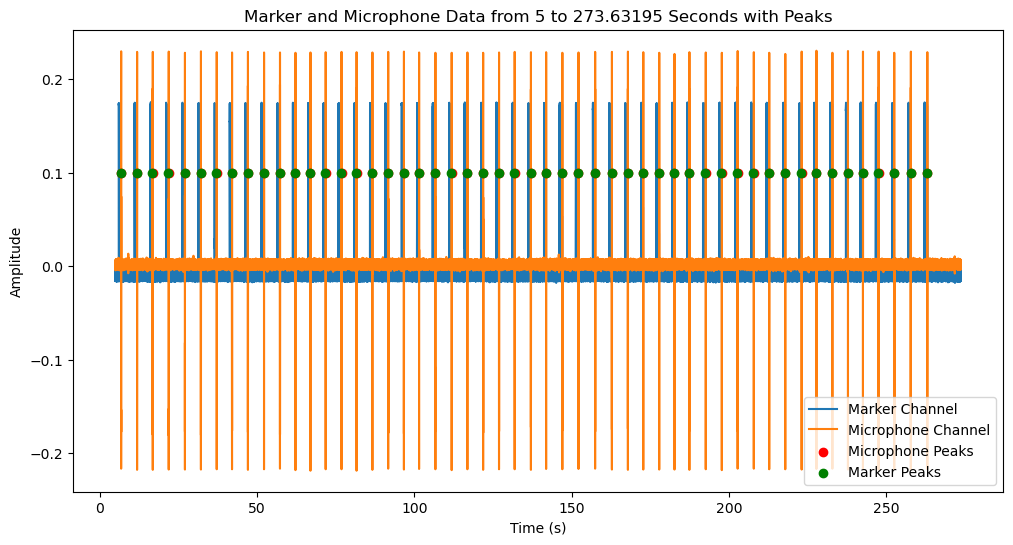

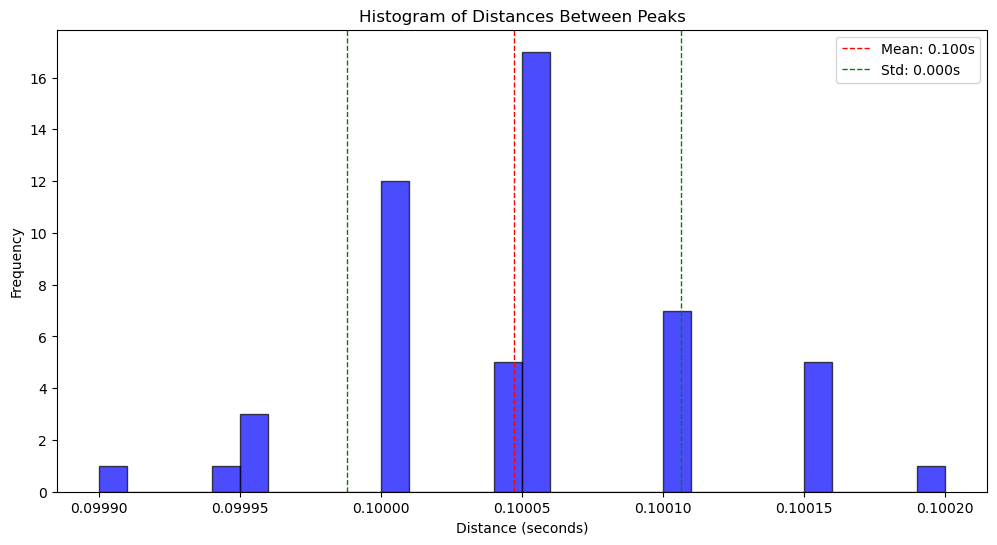

In [11]:
# Example of function usage:
distances = plot_peaks_within_interval(
    t=all_t,
    marker=all_marker,
    microphone=all_microphone,
    start_time=5,
    end_time=all_t[-1]
)
# Calculate mean and standard deviation

# Convert distances to numpy array for calculations
distances_array = np.array(distances)
mean_distance = np.mean(distances_array)
std_distance = np.std(distances_array)

# Plot histogram of distances
plt.figure(figsize=(12, 6))
plt.hist(distances_array, bins=30, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Distances Between Peaks")
plt.xlabel("Distance (seconds)")
plt.ylabel("Frequency")
plt.axvline(mean_distance, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_distance:.3f}s')
plt.axvline(mean_distance + std_distance, color='green', linestyle='dashed', linewidth=1, label=f'Std: {std_distance:.3f}s')
plt.axvline(mean_distance - std_distance, color='green', linestyle='dashed', linewidth=1)
plt.legend()
plt.show()